**Author** : Ayoub Choukri

**Date** : 08 October 2023

**Description** : This notebook contains the code to predict heart disease using MCA and descriptive statistics.

Please in order to run the code, you need to run the notebook outside of Kagel, because the mca package is not installed in Kagel.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from mca import MCA
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing the DataSet

Let's import our DataSet.

I will modify the display option for maximal ease when viewing the DataFrame.

In [2]:
df = pd.read_csv("Data/heart_disease_health_indicators.csv")
pd.set_option('display.max_columns', None)

Let's have a look to our DataSet.

In [3]:
df.sample(5)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
63922,0,1,1,1,30,1,1,0,1,1,1,0,1,0,3,0,2,0,1,11,5,5
201881,0,0,0,1,35,1,0,0,0,1,1,0,1,0,3,0,10,0,0,8,4,6
50184,0,0,0,1,18,1,0,0,0,1,1,0,1,0,4,25,12,0,0,3,3,5
211276,0,0,0,1,29,1,0,0,1,1,1,0,1,0,2,0,0,0,0,11,5,8
44643,0,1,0,1,27,0,1,0,1,1,1,0,1,0,4,0,10,0,0,6,4,1


We see that the DataSet has 253661 rows and 22 Columns. All the varaibles can be considered as categorical (Equivalent to Factor in R) except `BMI` and `Age`. First let's check if there are missing values in our DataSet.

In [4]:
df.isnull().sum()

HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

We therefore notice that there is no zero value. Now let's convert the qualitative variables into categories.

In [5]:
df[df.columns]=df[df.columns].astype('category')
df[['BMI','Age']]=df[['BMI','Age']].astype('float64')
df.dtypes

HeartDiseaseorAttack    category
HighBP                  category
HighChol                category
CholCheck               category
BMI                      float64
Smoker                  category
Stroke                  category
Diabetes                category
PhysActivity            category
Fruits                  category
Veggies                 category
HvyAlcoholConsump       category
AnyHealthcare           category
NoDocbcCost             category
GenHlth                 category
MentHlth                category
PhysHlth                category
DiffWalk                category
Sex                     category
Age                      float64
Education               category
Income                  category
dtype: object

# Descriptive Statistics

In this part, I am going to make a descriptive analysis of my DataSet.

First let's plot the variables to see how they beheave.

### Quantitative Variables

`Age` and `BMI` are the only continous variables that we have in our DataSet. For the number of bins, we are going to use `Freedman-Diaconis`, which says that : 

$$ h = 2 \frac{IQ(x)}{\sqrt[3]{n}}$$

Where $h$ is the bin's width.

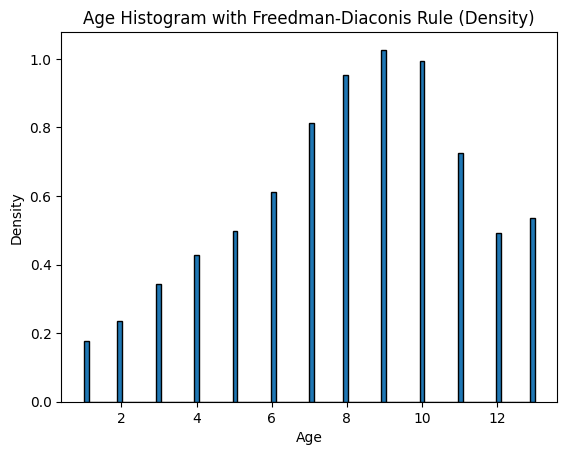

In [6]:
# Calculate the optimal bin width using the Freedman-Diaconis rule
iqr = np.percentile(df['Age'], 75) - np.percentile(df['Age'], 25)
h = 2.0 * iqr * (df.shape[0] ** (-1/3))

# Create a histogram with the number of bins based on the optimal bin width
num_bins = int((df['Age'].max() - df['Age'].min()) / h)


plt.hist(df['Age'], bins=num_bins, density=True, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Histogram with Freedman-Diaconis Rule (Density)')
plt.show()

/home/ayoub/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ayoub/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Density'>

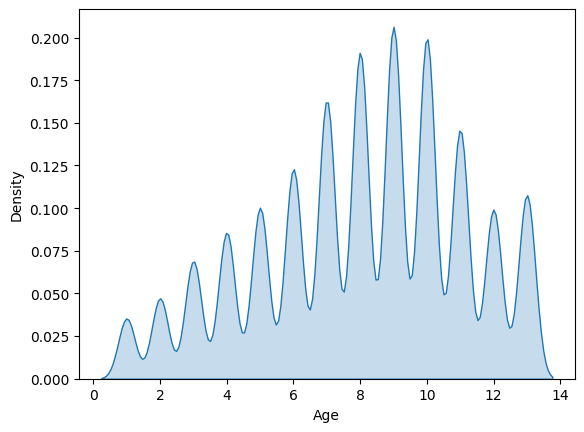

In [7]:
sns.kdeplot(data=df,x='Age',fill=True)


We can observe that the ages in the data are relatively low, suggesting that the dataset may be related to children or individuals of a younger age group. 

The age distribution of individuals in the study exhibits a left-skewed pattern, as evidenced by a greater concentration of individuals with ages on the higher end of the spectrum. Specifically, the majority of study participants fall within the age range of 8 to 10 years. 

Also, we notice some fluctuations in the estimated density of `Age`, which may be due to the small number of observations in the dataset of individuals with ages between two integers (eg 8.5, 9.5, etc.).

Let's see `BMI`.

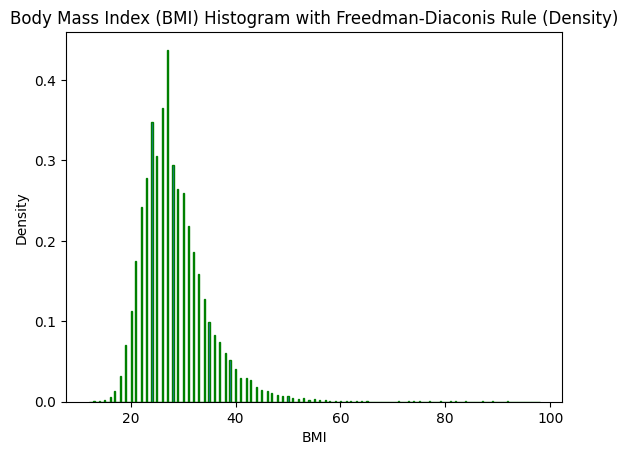

In [8]:
# Calculate the optimal bin width using the Freedman-Diaconis rule
iqr = np.percentile(df['BMI'], 75) - np.percentile(df['BMI'], 25)
h = 2.0 * iqr * (df.shape[0] ** (-1/3))

# Create a histogram with the number of bins based on the optimal bin width
num_bins = int((df['BMI'].max() - df['BMI'].min()) / h)


plt.hist(df['BMI'], bins=num_bins, density=True, edgecolor='green')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.title('Body Mass Index (BMI) Histogram with Freedman-Diaconis Rule (Density)')
plt.show()

/home/ayoub/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ayoub/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='BMI', ylabel='Density'>

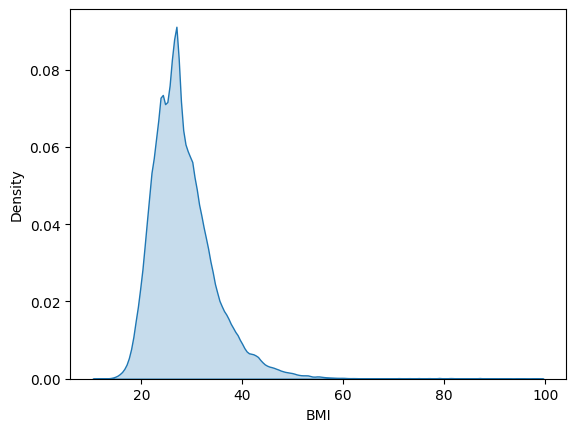

In [9]:
sns.kdeplot(data=df,x='BMI',fill=True)




We can observe that the majority of indiviuals have a BMI $\in \left[25,35\right]$. This concentration of BMIs within this interval indicates a prevalence of individuals with BMIs considered to be in the overweight to moderately obese range.

Moreover, the distribution of BMI among the study's participants displays a right-skewed pattern. This skewness to the right implies that while there is a substantial presence of individuals within the aforementioned BMI range, there are relatively fewer individuals with significantly lower BMIs, contributing to the skewness in the distribution.

This observation sheds light on the BMI profile of the study population, suggesting a higher incidence of individuals with elevated BMIs, which can have implications for further analysis or research considerations."







### Qualitative Variables

#### Pie Charts

In [10]:
pie_var = list(set(df.columns) - {'BMI','Age','Income','Education','PhysHlth','GenHlth','MentHlth'})

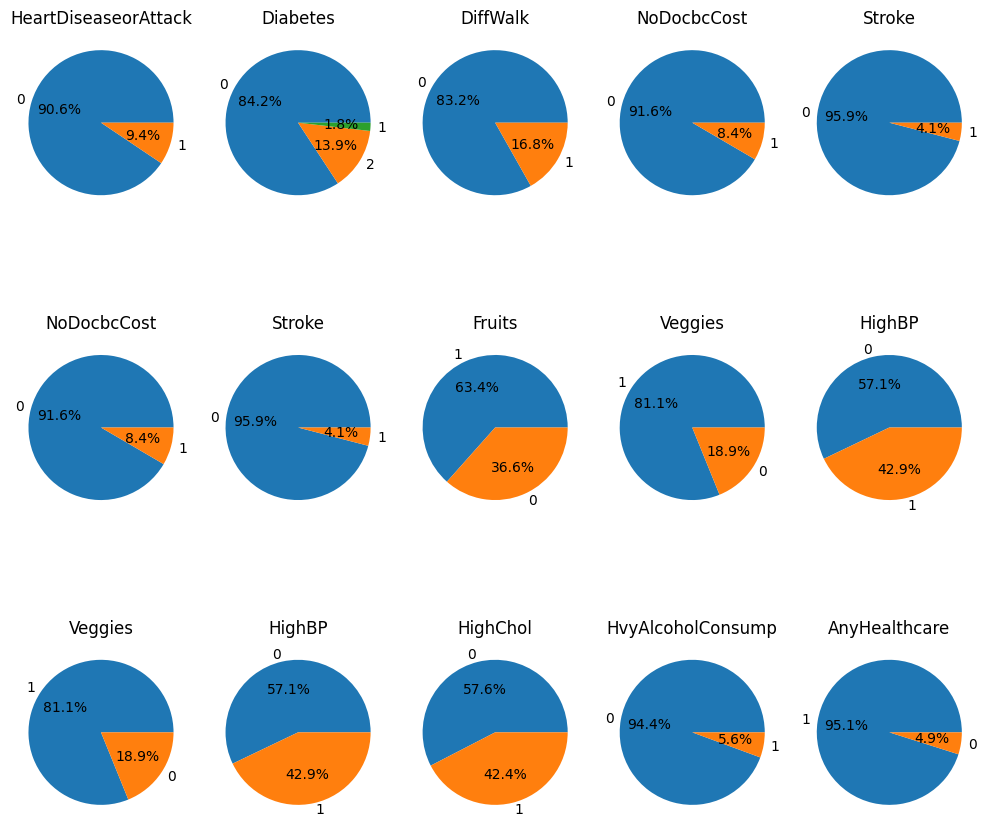

In [11]:
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
for i in range(3):
    for j in range(5):
        value_count = df.loc[:,pie_var [(3*i+j)]].value_counts()
        axes[i,j].pie(value_count,labels=value_count.index,autopct='%1.1f%%', startangle=0)
        axes[i, j].set_title(pie_var [3*i+j])
        #axes[i, j].legend(value_count.index, title=df.columns[i+j],loc='best')

plt.tight_layout()

We can deduce from the piecharts, that the majority of our individuals, do not have a `High Blood Pressure Status` $57.1%$, do not have a `High Cholesterole`, and many other dedcutions.

#### Bar Plots

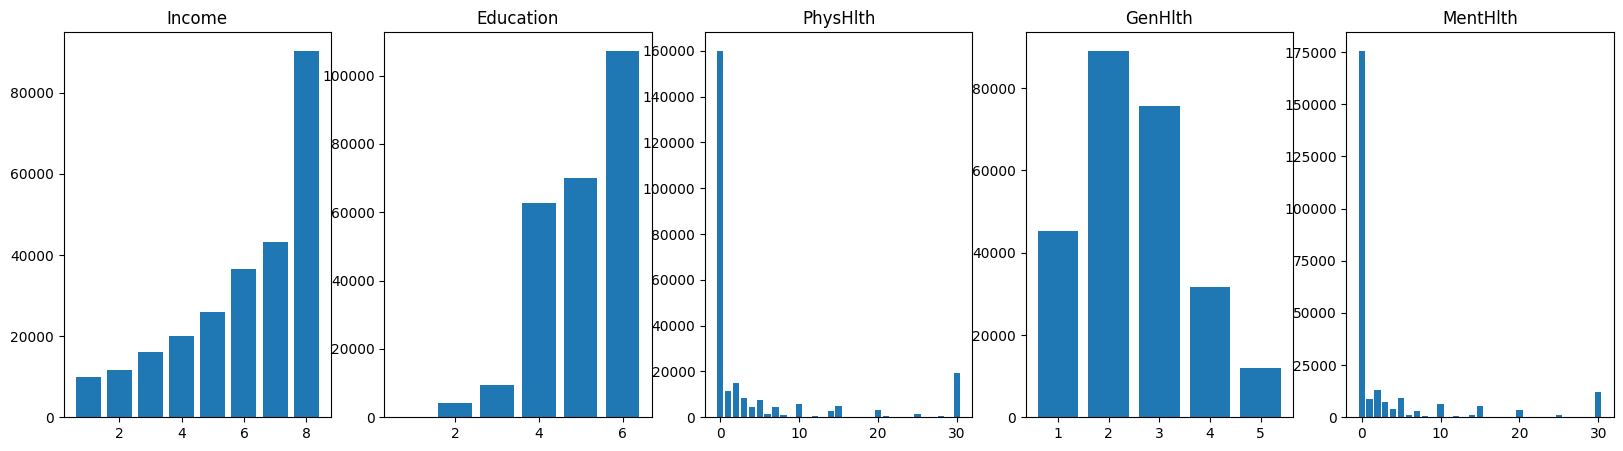

In [12]:
bar_var = ['Income','Education','PhysHlth','GenHlth','MentHlth']
fig, axes = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    # Plot a bar chart in the current axis using data from 'df'
    value_counts = df[bar_var[i]].value_counts()
    axes[i].bar(value_counts.index,value_counts ) 

    # Set the title of the current axis
    axes[i].set_title(bar_var[i])


Let's now dive into the bivariate analysis.

# Bivariate Analysis

In this part, i am going to mainly rely on the CA algorithm, in order to indetify what variables could be correlated with `HeartDiseaseorAttack` .

Let's import mca.

In [13]:
from mca import MCA

### Discretization of Continuous Variables

First, let's encode and discretse the quantitative variables `Age` and `BMI`.

In [14]:
df['Age'] = pd.qcut(df['Age'], 3,labels=['Age_0','Age_1','Age_2'])
df['BMI'] = pd.qcut(df['BMI'], 3,labels=['BMI_0','BMI_1','BMI_2'])

Considering the fact that our data set containt over $200 000$ rows. Doing MCA on this data set, will certainly be costy in time and memory.


For this reason, we are going to select $n$ individuals randomly and perform MCA.

Moreover, the dataset, contains $22$ variables, with more than $2$ levels. Which means that our disjonctive table will contain at minimul $44$ variables. Therefore, we are going to perform MCA on our target variable with all the other variables to identify correspondances.



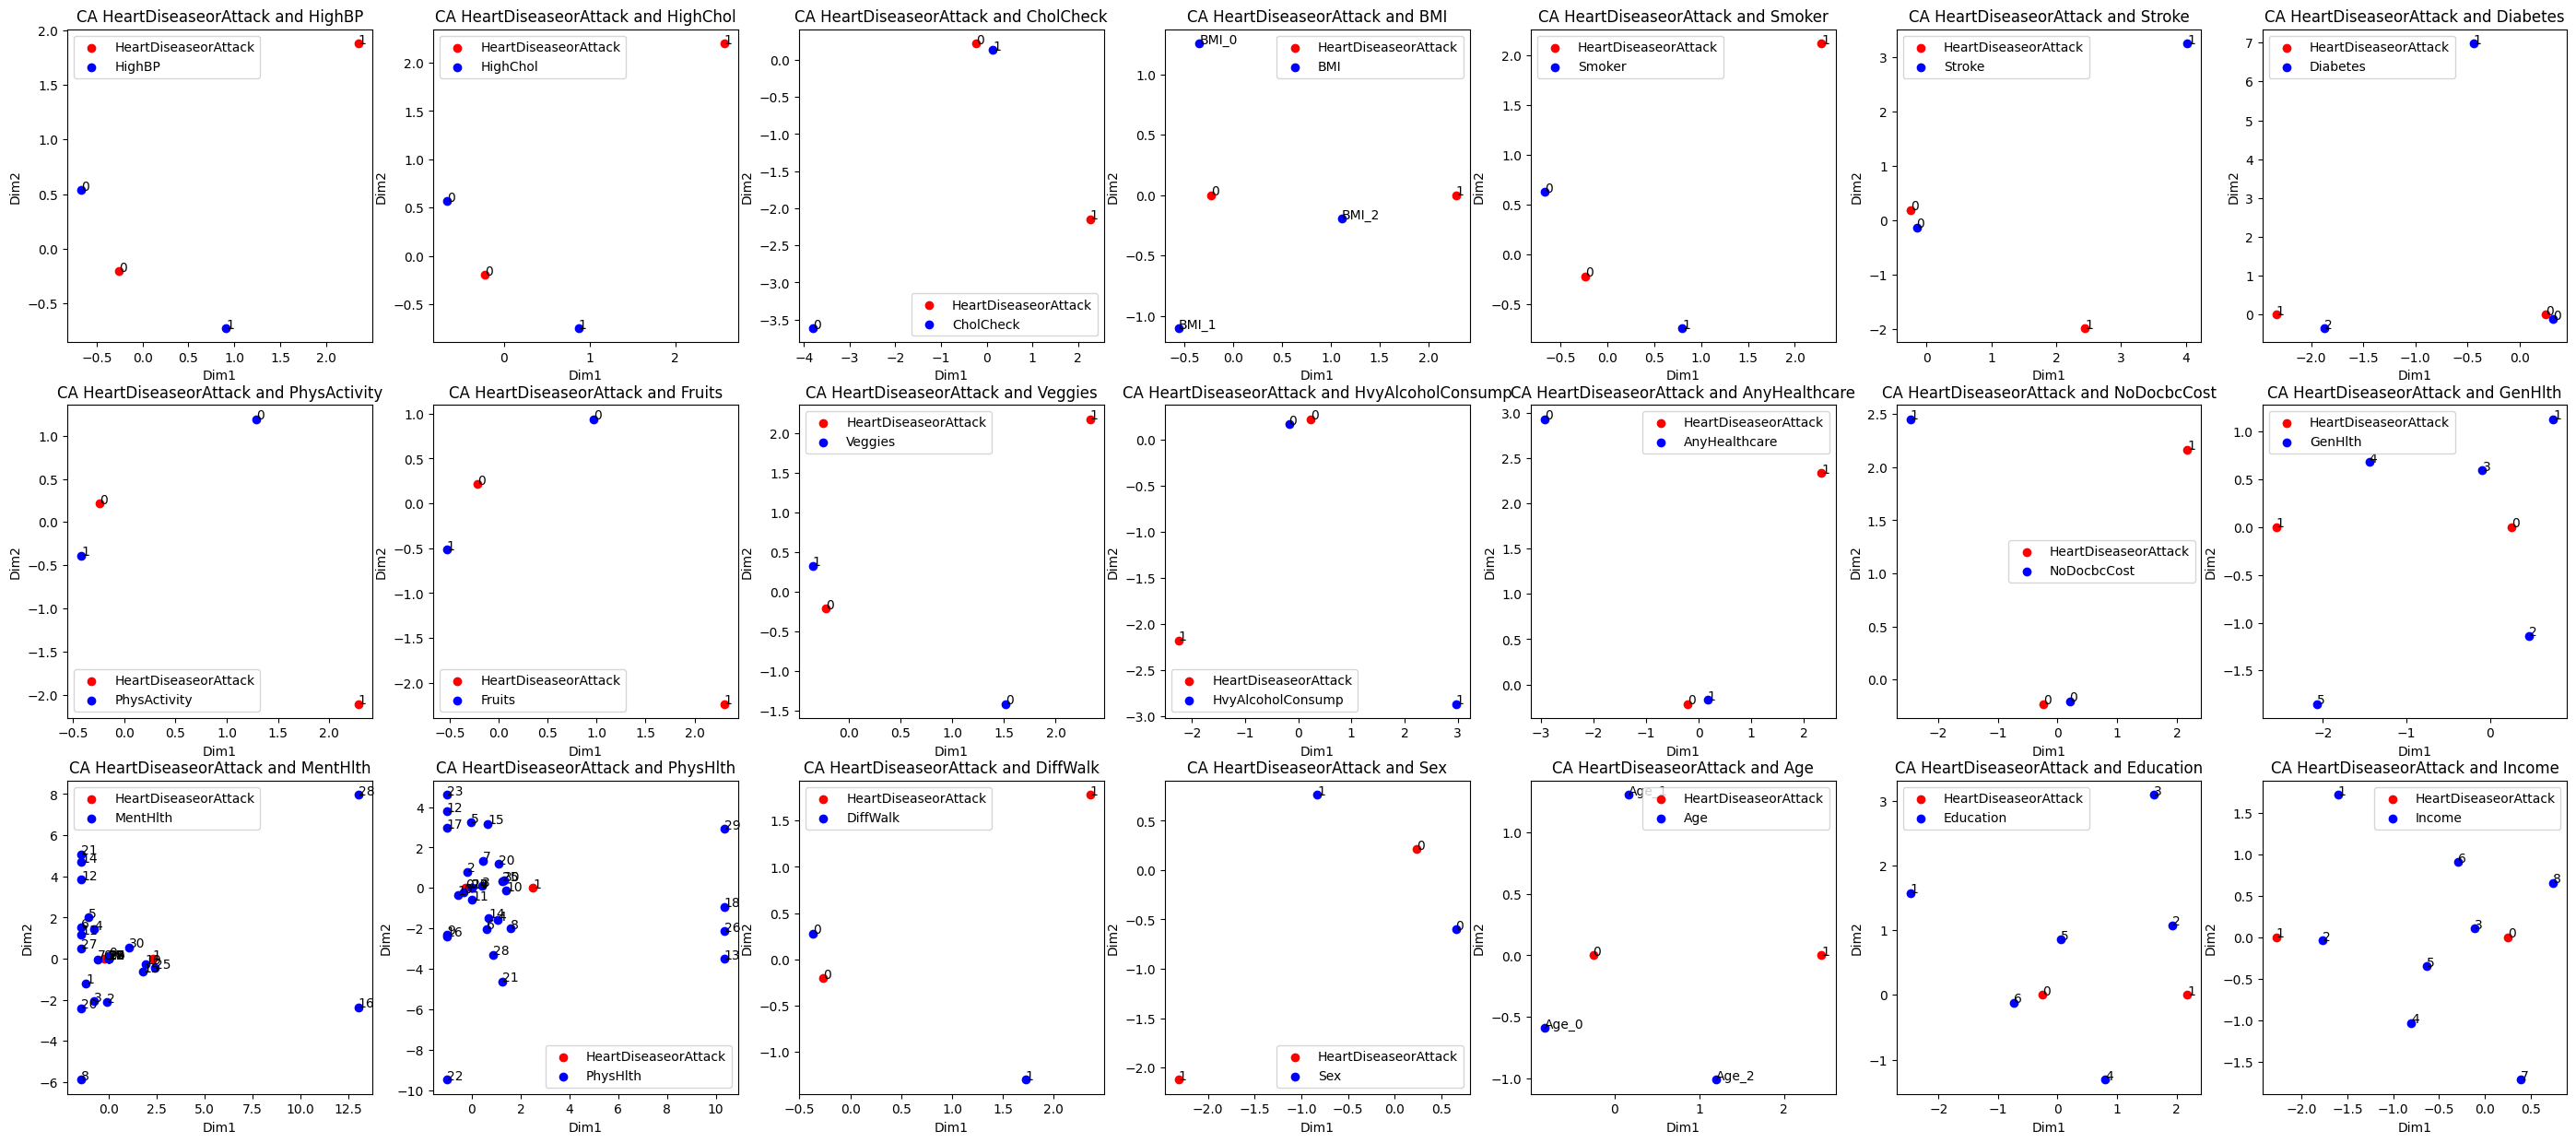

In [19]:
ntot = df.shape[0]
n = 2000



l=3
c=7

fig, axes = plt.subplots(l, c, figsize=(35, 15))

# Loop through rows and columns of subplots
for a in range(l):
    for b in range(1,c+1):
        # Select columns for MCA analysis based on random indices
        selected_columns = [0,c*a+b]
        subset_df = df.sample(n).iloc[:,selected_columns]
        # Create indicator variables for the selected columns
        dc = pd.get_dummies(subset_df,prefix='',prefix_sep='')
        # Perform MCA on the dummy variables
        mcaFic = MCA(dc, benzecri=False)
        # Scatter plot of the first two dimensions of MCA results
        fs_c = mcaFic.fs_c(N=2)
        axes[a, b-1].scatter(fs_c[:2, 0],fs_c[:2, 1],color='red')
        axes[a, b-1].scatter(fs_c[2:, 0], fs_c[2:, 1],color='blue')
        # Add labels to the points on the scatter plot using column names
        for i, j, nom in zip(fs_c[:, 0], fs_c[:, 1], dc.columns):
            axes[a, b-1].text(i, j, nom)
        axes[a,b-1].set_title("CA HeartDiseaseorAttack and "+str(df.columns[7*a+b]))
        axes[a,b-1].set_xlabel("Dim1")
        axes[a,b-1].set_ylabel("Dim2")
        axes[a,b-1].legend(['HeartDiseaseorAttack',df.columns[c*a+b]])




### Deductions:

After performing the CA (Correspondence Analysis) analysis, we can extract some insightful observations regarding the likelihood of individuals experiencing a heart attack:

1. **Cholesterol Check**: Individuals who undergo regular cholesterol checks tend to have a lower risk of experiencing a heart attack.

2. **BMI (Body Mass Index)**: Those with a lower BMI generally have a reduced likelihood of suffering a heart attack.

3. **Diabetes**: Individuals without diabetes are associated with a decreased risk of a heart attack. However, it's important to note that individuals with type 2 diabetes have a significantly higher risk of experiencing a heart attack.

4. **Alcohol Consumption**: People who consume alcohol in moderation or avoid excessive alcohol consumption tend to have a lower likelihood of having a heart attack.

5. **Income** : People with an income grade of $8$,$5$ or $6$ have a lower risk of heart attack.


These insights, derived from the CA analysis, can be valuable for understanding the factors that contribute to heart attack risk and for guiding preventive measures and healthcare strategies.


### Remark

This results can be biased, because insteaf of `MCA`, we applied multiple times `CA` on the data set selecting `HearthDiseaseorAttack` and every other variable at each tile. Which means that we are not taking into account the variance of the other variables. Therefore, we are going to perform `MCA` on the data set with all the variables.

# Real MCA

Let's perform MCA on the data set with all the variables.

First we store all the variables that are going to be used in the MCA in a list.

In [16]:
mca_all_columns = df.columns

Considering the fact that our data set containt over $200 000$ rows. Doing MCA on this data set, will certainly be costy in time and memory. Therefore, we are going to select $n$ individuals randomly and perform MCA.

In [17]:
ntot = df.shape[0]
n = 20000


# Loop through rows and columns of subplots


# Select columns for MCA analysis based on random indices
subset_df = df.sample(n)[mca_all_columns]
# Create indicator variables for the selected columns
dc = pd.get_dummies(subset_df,prefix='',prefix_sep='')
# Perform MCA on the dummy variables
mcaFic = MCA(dc, benzecri=False)
# Scatter plot of the first two dimensions of MCA results
fs_c = mcaFic.fs_c()



In [18]:
mca_dict=dict()

bef=0
for col in mca_all_columns :
    value_counts = df[col].value_counts()
    mca_dict[col] = pd.DataFrame(fs_c[bef:(bef+value_counts.shape[0]),:], index=dc.columns[bef:(bef+value_counts.shape[0])])

    bef += value_counts.shape[0]

In [19]:
import colorsys

def generate_rainbow_palette(num_colors):
    colors = []
    for i in range(num_colors):
        hue = i / num_colors  # Variation de la teinte de 0 à 1
        rgb = colorsys.hsv_to_rgb(hue, 1, 1)  # Convertir la teinte en RVB
        colors.append((int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
                     )  # Conversion des valeurs RVB de 0-1 à 0-255
    return colors

palette = generate_rainbow_palette(30)
print(palette)

[(255, 0, 0), (255, 50, 0), (255, 102, 0), (255, 153, 0), (255, 204, 0), (255, 255, 0), (203, 255, 0), (153, 255, 0), (101, 255, 0), (51, 255, 0), (0, 255, 0), (0, 255, 50), (0, 255, 102), (0, 255, 153), (0, 255, 203), (0, 255, 255), (0, 203, 255), (0, 153, 255), (0, 102, 255), (0, 51, 255), (0, 0, 255), (50, 0, 255), (101, 0, 255), (153, 0, 255), (204, 0, 255), (255, 0, 255), (255, 0, 203), (255, 0, 152), (255, 0, 102), (255, 0, 51)]


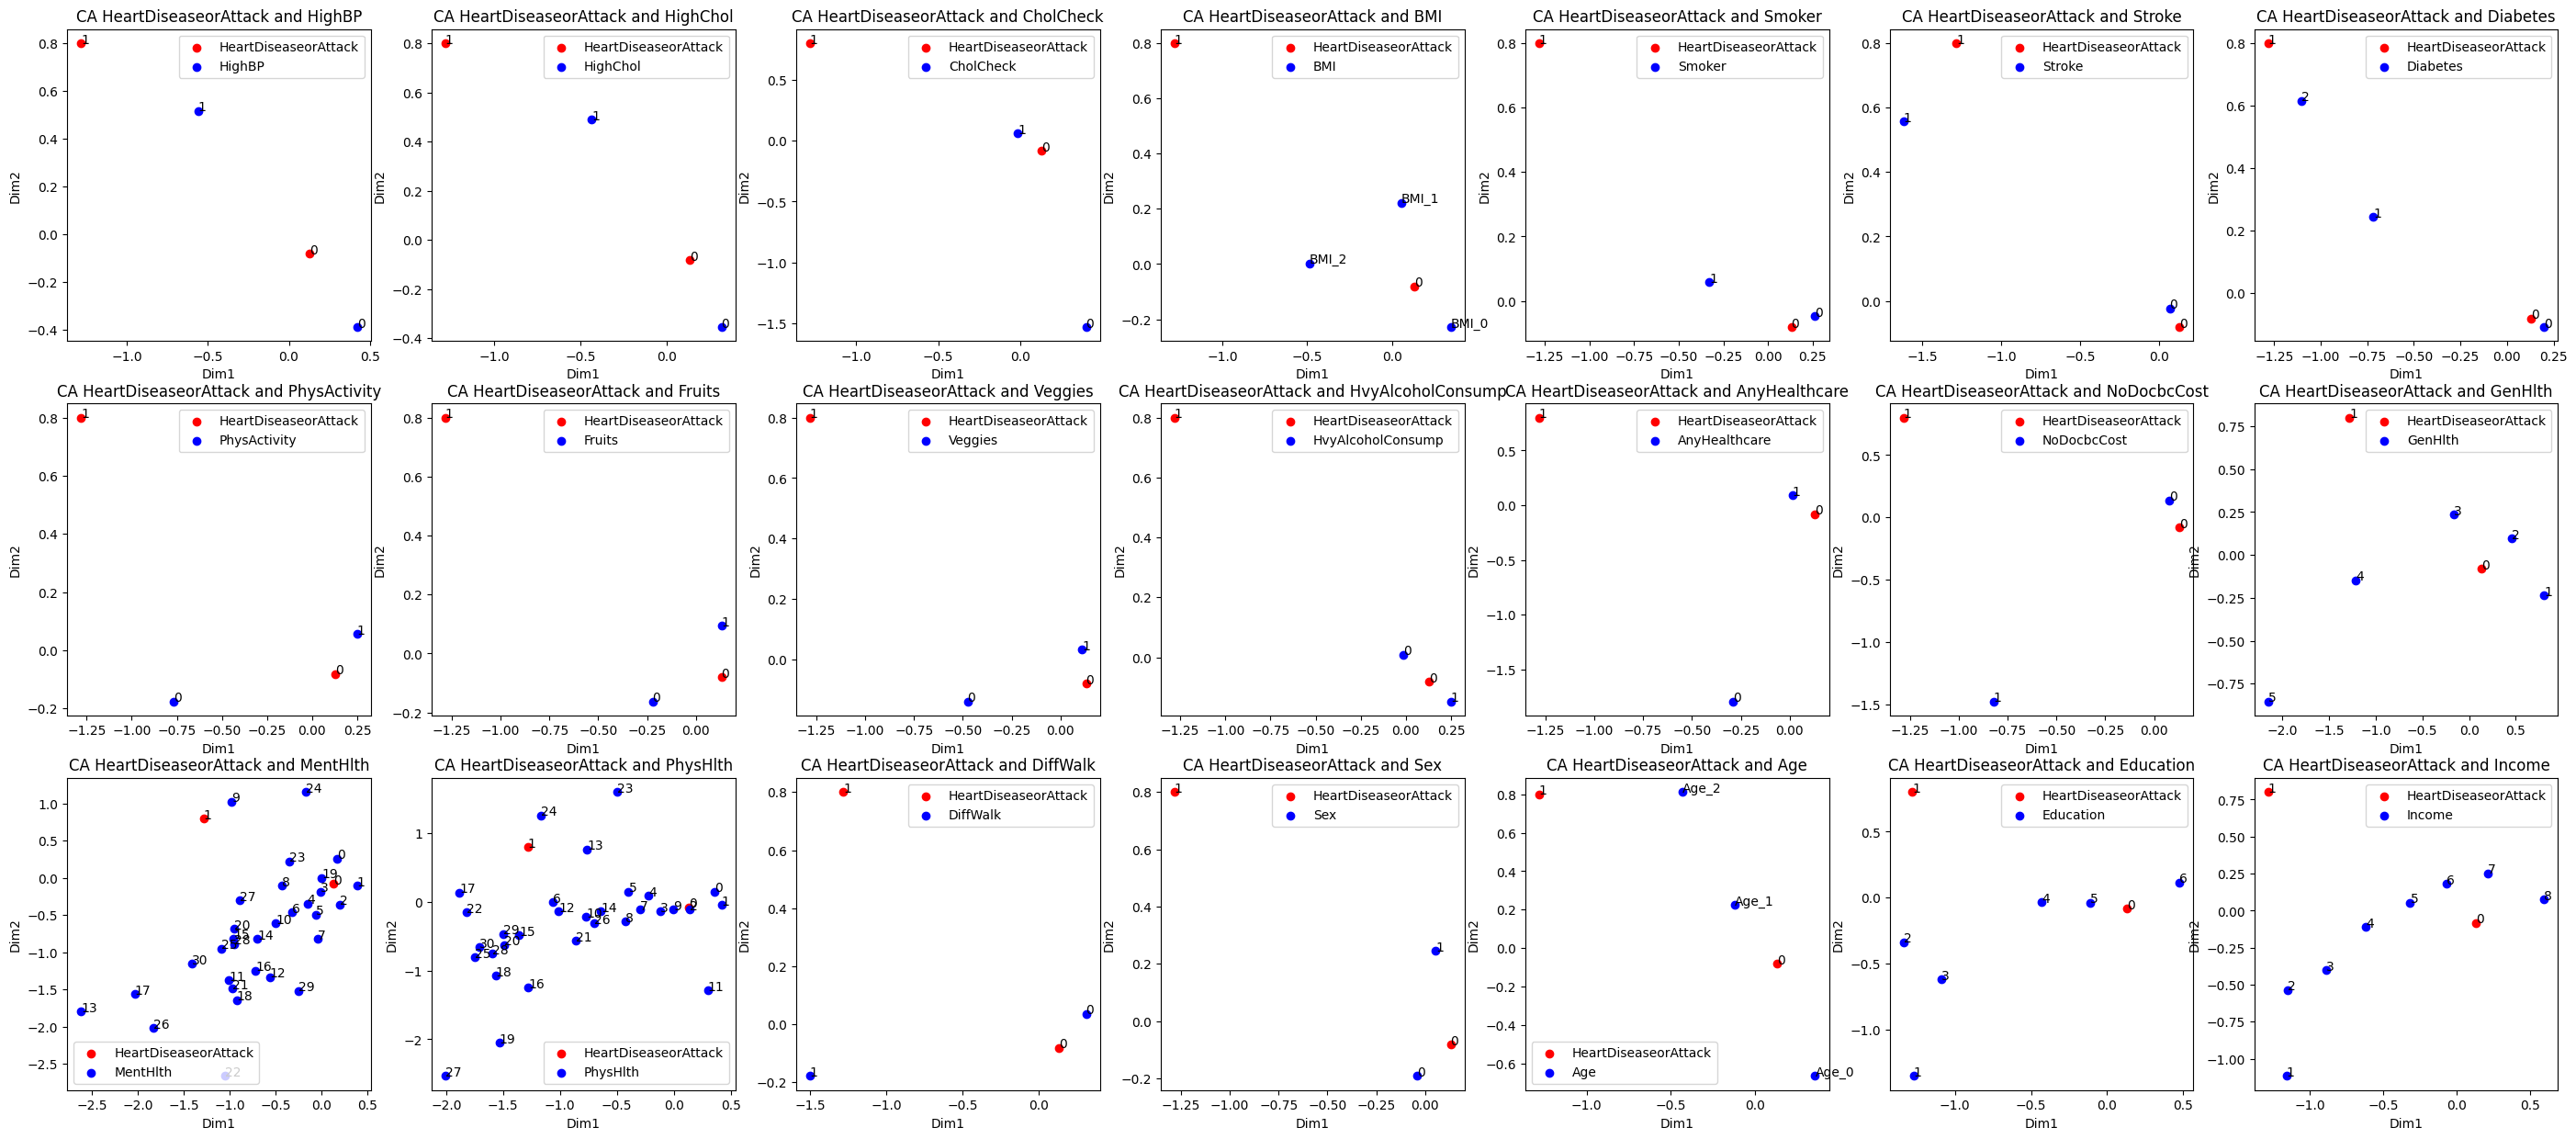

In [20]:
l=3
c=7

fig, axes = plt.subplots(l, c, figsize=(35, 15))
# Loop through rows and columns of subplots
bef=2
for a in range(l):
    for b in range(1,c+1):
        value_counts= df[mca_all_columns[c*a+b]].value_counts()
        axes[a, b-1].scatter(fs_c[:2, 0],fs_c[:2, 1],color='red')
        axes[a, b-1].scatter(fs_c[bef:bef+value_counts.shape[0], 0], fs_c[bef:bef+value_counts.shape[0], 1], color='blue')

        
        # Add labels to the points on the scatter plot using column names
        for i, j, nom in zip(fs_c[0:2, 0], fs_c[0:2, 1], dc.columns[0:2]):
            axes[a, b-1].text(i, j, nom)
        for i, j, nom in zip(fs_c[bef:bef+value_counts.shape[0], 0], fs_c[bef:bef+value_counts.shape[0], 1], dc.columns[bef:bef+value_counts.shape[0]]):
            axes[a, b-1].text(i, j, nom)
        bef+= value_counts.shape[0]
        axes[a,b-1].set_title("CA HeartDiseaseorAttack and "+str(df.columns[7*a+b]))
        axes[a,b-1].set_xlabel("Dim1")
        axes[a,b-1].set_ylabel("Dim2")
        axes[a,b-1].legend(['HeartDiseaseorAttack',df.columns[c*a+b]])




### Deductions :

The results of the MCA analysis are consistent with the findings of the CA analysis. However, there are some differences between the two analyses. For example, the MCA analysis indicates that individuals with a higher income level are associated with a lower risk of heart attack, whereas the CA analysis isn't clear about the relation between `Income` and `HearthDiseaseorAttack`. This discrepancy may be due to the fact that the CA analysis was performed on a subset of the data, whereas the MCA analysis was performed on the entire dataset.

Moreover, the MCA analysis indicates some more relations between the variables and the target variable `HearthDiseaseorAttack`. For example :

* People who have a `High Blood Pressure Status` are more likely to have a heart attack.
* People who have a `High Cholesterole` are more likely to have a heart attack.
* Alcohol Consumption does not seem to have an impact on the risk of heart attack.

# Thank you for reading this notebook.